### How to apporach this assignment

You can find all the blanks with the `### TODO ###` tag.

#### Current Structure of the codebase
- Toy Dataset Generation: gen_data (checkboard, mul_circle, spiral, moon, circle, blob)
- Activation Functions Class: AF (linear, sigmoid, tanh, relu, softmax, leaky_relu, selu)
- Loss Function Class: LF (We will only implement Softmax + Cross Entropy this time)
- The NN Model: SimpleNN (Defined a NN with list of neuron count and activation function)
- Optimizer Classes: Optimizer (SGD, SGDMomentum, SGDNesterovMomentum, Adagrad, RMSprop, Adam)
- Training Scheduler: StopScheduler (EarlyStopScheduler)
- Learning Rate Scheduler: LRScheduler (ReduceLROnPlateau)
- Utility Functions: grouper (Group data into mini-batches)
- Training Loop: train_model (The main function to train a model)
- Animation functions for the training process: draw_process, calculate_model_boundary, draw_model_boundary, draw_metrics_history
    - You can skip understanding these

#### Step 1
- Get an understanding of the Training Loop
    - We first call gen_data to get: class_cnt, training_data, validation_data, testing_data
    - We define our model structure and inital our SimpleNN model
    - We define our optimizer, lr_scheduler, stop_scheduler
    - We run through train_model with (model, optimizer, lr_scheduler, stop_scheduler, training_data, validation_data)
    - We can look at training process with draw_process
    - We evaluate our model through model.evaluate and look at accuracy and model boundary using draw_model_boundary

#### Step 2
- Understand the SimpleNN model
    - `__init__` will init the weights and biases
    - `empty_structure` will return an empty model will all weight and biases to be zero (Will be helpful later on)
    - `activation_func` and `loss_func` are wrappers functions to call the real functions
    - `forward` and `backprop` are the forward and backward pass of the neural net
        - `return_activations` in the forward pass is for usage in the backward pass
        - We return the delta of weight and biases for this x and y in `backprop`, this will be passed to the optimzer to decide the real delta
    - `update_one_batch_optimizer` is for getting the average delta to the model in the mini-batch
        - We will pass the delta to the optimizer and let it decide how it will change the weight and biases
    - `loss_one` and `loss` is for returning the loss
    - `evaluate_one` and `evaluate` is for returning the evaluation result

#### Step 3
- Make the `Basic Run` loop work by filling in some blanks
    - Implement forward/backward pass in SimpleNN
        - The forward and backward pass needs to be in vector form
    - Implement one of the Activation Functions (Eg. Relu)
        - The parameter d means derivative
    - Implement the Loss Function
        - We implement Softmax + Cross Entropy combined loss
    - Implement SGD to have one working optimizer
        - Naive SGD will just be to multiply the delta by the learning rate and update the weight and biases
    - Implement grouper function for making mini-batches

#### Step 4
- We shall be able to run through the `Basic Run` loop and see the training process happen!

#### Step 5
- Implment other Activation Functions
    - linear, sigmoid, tanh, relu, softmax, leaky_relu, selu
- Implement other Optimizers
    - SGDMomentum, SGDNesterovMomentum, Adagrad, RMSprop, Adam
- Implement other weights and biases initalization methods
    - Normalized Standard Normal
- Implment early stopping and learning rate decay
    - EarlyStopScheduler
    - ReduceLROnPlateau
    
#### Step Final
- Finish with the experiments detailed at the bottom
    - Try out different Toy Datasets
        - Must: "checkboard", "spiral", "mul_circle"
        - Others: "circle", "moon", "blob"
    - Try out different activation functions
        - Must: AF.linear, AF.sigmoid, AF.tanh, AF.relu
        - Others: AF.leaky_relu, AF.selu ...
    - Try out Different Optimizers
        - Must: SGD, SGD+Momentum, RMSprop, Adam
        - Others: SGD+NesterovMomentum, Adagrad
    - Try out different Gradient Descent Methods
        - Must: Batch, Stochastic, Mini-batch with different batch size
    - Try out different model structures (deep vs shallow / wide vs thin)
        - Must: (4)x1, (2)x4, (4)x2
        - Others: (4)x3 ...
    - Try out other weights and biases initalization methods
    - Try out early stopping
    - Try out learning rate decay

# 由於在趕DLP作業加上禮拜四要報paper，這禮拜只有把Must的地方做完並簡單做一些比較，還請見諒

### Import Libaries
Since we imported numpy, you shall not need any more libaries

In [123]:
from itertools import zip_longest
from typing import List, Tuple, Callable, Optional

# Vector Operations
import numpy as np

# For Generating Datasets
from sklearn.datasets import make_circles, make_moons, make_blobs, make_gaussian_quantiles
from sklearn.model_selection import train_test_split

# Progress Bar
from tqdm.auto import tqdm

# Plotting Diagrams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Plotting Animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [124]:
# Increase figure size
plt.rcParams["figure.figsize"] = (12, 8)

### There are 6 generated datasets that you can use to try out your model

- Must try:
    - checkboard: XOR like Pattern
    - mul_circle: class_cnt rings of Data
    - spiral: Spiral Shape (From CS231n)
- Others:
    - moon: Two semi-circle
    - circle: Two rings of Data
    - blob: class_cnt Guassian Distribution

In [125]:
ALL_DATA_TYPE = ["checkboard", "circle", "mul_circle", "moon", "blob", "spiral"]

def gen_data(name, per_class_data_cnt=500, class_cnt=3, show_data=False):
    n_samples = per_class_data_cnt * class_cnt
    if name == "circle":
        class_cnt = 2
        X, Y = make_circles(n_samples=n_samples, noise=0.2, factor=0.3)
    elif name == "mul_circle":
        X, Y = make_gaussian_quantiles(n_samples=n_samples, n_features=2, n_classes=class_cnt)
    elif name == "moon":
        class_cnt = 2
        X, Y = make_moons(n_samples=n_samples, noise=0.1)
    elif name == "blob":
        X, Y = make_blobs(n_samples=n_samples, n_features=2, centers=class_cnt)
    elif name == "checkboard":
        class_cnt = 2
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)
        offsets = [((1, 1), 0), ((1, -1), 1), ((-1, 1), 1), ((-1, -1), 0)]
        for bid, (offset, y) in enumerate(offsets):
            idx = range(per_class_data_cnt*bid//2, per_class_data_cnt*(bid+1)//2)
            X[idx] = (np.random.rand(per_class_data_cnt//2, 2) + 0.05) * np.array(offset)
            Y[idx] = y
    elif name == "spiral":
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)
        for cid in range(class_cnt):
            r = np.linspace(0.0, 1, per_class_data_cnt) # radius
            t = np.linspace(cid*4, (cid+1)*4, per_class_data_cnt) + np.random.randn(per_class_data_cnt)*0.3 # theta
            idx = range(per_class_data_cnt*cid, per_class_data_cnt*(cid+1))
            X[idx] = np.c_[r*np.sin(t), r*np.cos(t)]
            Y[idx] = cid
    else:
        raise ValueError("Unknown Data Name!")

    if show_data:
        plt.scatter(X[:, 0], X[:, 1], c=Y, s=20)
        plt.show()
        
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.25)

    # Change index to one hot (Assumes index 0 ~ class_cnt)
    # [1, 2, 0, 1] -> [[0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0]]
    def one_hot(x, class_cnt):
        oh = np.zeros((len(x), class_cnt))
        oh[np.arange(len(x)), [int(i) for i in x]] = 1
        return oh.reshape(-1, class_cnt, 1)

    training_data = list(zip(X_train.reshape(-1, 2, 1), one_hot(Y_train, class_cnt)))
    validation_data = list(zip(X_valid.reshape(-1, 2, 1), one_hot(Y_valid, class_cnt)))
    testing_data = list(zip(X_test.reshape(-1, 2, 1), one_hot(Y_test, class_cnt)))
    
    return class_cnt, training_data, validation_data, testing_data

### Demo of Spiral Data

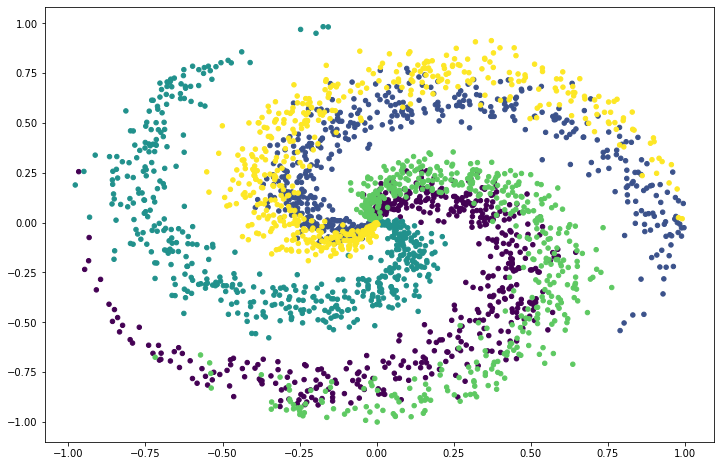

In [126]:
class_cnt, training_data, validation_data, testing_data = gen_data("spiral", class_cnt=5, show_data=True)

### List of Activation and Loss Functions

In [127]:
# Activation Functions
class AF():
    @staticmethod
    def linear(x, d=False):
        return 1 if d else x

    @staticmethod
    def sigmoid(x, d=False):
        return np.multiply(AF.sigmoid(x), 1.0 - AF.sigmoid(x)) if d else 1.0/(1.0 + np.exp(-x))

    @staticmethod
    def tanh(x, d=False):
        return 1-np.multiply(AF.sigmoid(x), AF.sigmoid(x)) if d else np.tanh(x)

    @staticmethod
    def relu(x, d=False):
        return np.where(x > 0, 1, 0) if d else np.where(x > 0, x, 0)

    @staticmethod
    def leaky_relu(x, alpha = 0.01,d=False):
        return np.where(x > 0, 1, alpha) if d else np.where(x > 0, x, alpha*x)

    @staticmethod
    def selu(x, alpha = 0.01, d=False):
        return np.where(x > 0, 1 , alpha * np.exp(x)) if d else np.where(x > 0, x, alpha*(np.exp(x)-1))

    @staticmethod
    def softmax(x, d=False):
        EPS = 1e-6
        if d:
            print("Shall not need!")
            return -1
        else:
            x -= np.max(x)
            x = np.exp(x) / np.sum(np.exp(x))
            return x
            

In [128]:
# Loss Functions
class LF():
    @staticmethod
    def softmax_crossentropy(activation_output, y, d=False):
        if d:
            grad = activation_output - y
            return grad
        else:
            loss = -np.sum(y * np.log(activation_output + 1e-10))
            return loss

### The NN Model

In [129]:
class SimpleNN():

    def __init__(self, structure: List[int], af: Callable):
        # Save the model structure
        self.layer_structure = structure
        self.num_layers = len(structure)
        self.af = af

        # Initialize the weight and bias
        # Weight Initialization: http://cs231n.github.io/neural-networks-2/
        # For weights:
        #   - Standard Normal: np.random.randn
        #   - Normalized Standard Normal: np.random.randn / np.sqrt(<previous_layer_neuron_cnt>)
        #   - Gaussian Normal: np.random.normal
        # For bias:
        #   - All zeros: np.zeros
        #   - Standard Normal: np.random.randn
        #   - Gaussian Normal: np.random.normal
        self.weights = [np.random.randn(nl, pl) for pl, nl in zip(structure[:-1], structure[1:])]
        self.biases = [np.zeros((l, 1)) for l in structure[1:]]

    def empty_structure(self):
        # Return empty structure for weight and bias
        return [np.zeros(w.shape) for w in self.weights], [np.zeros(b.shape) for b in self.biases]

    def activation_func(self, l: int, *args, **kargs):
        # Use softmax on last layer
        return AF.softmax(*args, **kargs) if l == self.num_layers-1 else self.af(*args, **kargs)

    def loss_func(self, *args, **kargs):
        return LF.softmax_crossentropy(*args, **kargs)

    def forward(self, x, return_activations=False):
        activations, before_activations = [x], []
        for i in range(self.num_layers - 1):
            x = np.dot(self.weights[i], x) + self.biases[i]
            before_activations += [x]
            x = self.activation_func(i + 1, x)
            activations += [x]

        # Return value history for backprop usage
        return (activations, before_activations) if return_activations else activations[-1]

    def backprop(self, x, y):
        # Init empty data structure to store delta
        delta_w, delta_b = self.empty_structure()

        # Feed forward pass
        activations, before_activations = self.forward(x, return_activations=True)

        # Backward pass
        delta = self.loss_func(activations[-1], y, d=True)
        delta_b[-1] = delta
        delta_w[-1] = np.dot(delta, activations[-2].T)
        
        for i in range(2, self.num_layers):
            idx = self.num_layers - i - 1
            delta = np.dot(self.weights[idx+1].T, delta) * self.activation_func(idx, before_activations[idx], d=True)
            delta_b[idx] = delta
            delta_w[idx] = np.dot(delta, activations[idx].T)

        return delta_w, delta_b
        
    def update_one_batch_optimizer(self, mini_batch, optimizer):
        # Init empty data structure to store delta
        batch_delta_w, batch_delta_b = self.empty_structure()
    
        # Run through the batch of data
        for x, ohy in mini_batch:
            delta_w, delta_b = self.backprop(x, ohy)
            batch_delta_w = [bd+d for bd, d in zip(batch_delta_w, delta_w)]
            batch_delta_b = [bd+d for bd, d in zip(batch_delta_b, delta_b)]
        
        # Average the delta among the same batch
        batch_delta_w = [bd/len(mini_batch) for bd in batch_delta_w]
        batch_delta_b = [bd/len(mini_batch) for bd in batch_delta_b]
        
        # Change the weights and biases by using the optimizer
        self.weights, self.biases = optimizer.step(self.weights, self.biases, batch_delta_w, batch_delta_b)
 
    def loss_one(self, x, y):
        return self.loss_func(self.forward(x), y)
    
    def loss(self, evaluate_data):
        return sum([self.loss_one(x, y) for x, y in evaluate_data]) / len(evaluate_data)

    def evaluate_one(self, x):
        return np.argmax(self.forward(x))

    def evaluate(self, evaluate_data):
        evaluation_result = [(x, np.argmax(y), self.evaluate_one(x)) for x, y in evaluate_data]
        accuracy = sum([y==pred for x, y, pred in evaluation_result]) / len(evaluate_data)
        return accuracy, evaluation_result

* ### All the Optimzers

http://cs231n.github.io/neural-networks-3/

In [130]:
class Optimizer():
    def __init__(self, empty_model_structure):
        # Save the empty model structure
        self.empty_model = empty_model_structure

    def step(weights, biases, batch_delta_w, batch_delta_b):
        # Update Weight and Bias accordingly to the average of deltas of the whole batch
        weights = [w+bd for w, bd in zip(weights, batch_delta_w)]
        biases = [b+bd for b, bd in zip(biases, batch_delta_b)]
        return weights, biases

class SGD(Optimizer):
    def __init__(self, empty_model_structure,
                 lr: float = 0.01):
        # Call Optimizer's init
        super(SGD, self).__init__(empty_model_structure)
        # Save Parameters
        self.lr = lr

    def step(self, weights, biases, batch_delta_w, batch_delta_b):
        # Multiply delta by lr
        ### TODO ###
        ret_batch_delta_w = [-self.lr * x for x in batch_delta_w]
        ret_batch_delta_b = [-self.lr * x for x in batch_delta_b]
        # Update Weight and Bias accordingly
        weights = [w+bd for w, bd in zip(weights, ret_batch_delta_w)]
        biases = [b+bd for b, bd in zip(biases, ret_batch_delta_b)]
        return weights, biases

class SGDMomentum(Optimizer):
    def __init__(self, empty_model_structure,
                 lr: float = 0.01, momentum: float = 0.9):
        # Call Optimizer's init
        super(SGDMomentum, self).__init__(empty_model_structure)
        # Save Parameters
        self.lr = lr
        self.momentum = momentum
        # Initial momentum storage
        self.momentum_w, self.momentum_b = self.empty_model

    def step(self, weights, biases, batch_delta_w, batch_delta_b):
        # Multiply delta by lr and add previous batch momentum
        ### TODO ###
        ret_batch_delta_w = [-x * self.lr for x in batch_delta_w] + [x * self.momentum for x in self.momentum_w]
        ret_batch_delta_b = [-x * self.lr for x in batch_delta_b] + [x * self.momentum for x in self.momentum_b]
        # Save current delta for future momentum usage
        ### TODO ###
        self.momentum_w = ret_batch_delta_w
        self.momentum_b = ret_batch_delta_b

        # Update Weight and Bias accordingly
        weights = [w+bd for w, bd in zip(weights, ret_batch_delta_w)]
        biases = [b+bd for b, bd in zip(biases, ret_batch_delta_b)]
        return weights, biases

class SGDNesterovMomentum(Optimizer):
    def __init__(self, empty_model_structure,
                 lr: float = 0.01, momentum: float = 0.9):
        # Call Optimizer's init
        super(SGDNesterovMomentum, self).__init__(empty_model_structure)
        # Save Parameters
        self.lr = lr
        self.momentum = momentum
        # Initial momentum storage
        self.momentum_w, self.momentum_b = self.empty_model

    def step(self, weights, biases, batch_delta_w, batch_delta_b):
        # Save current momentum first
        prev_momentum_w, prev_momentum_b = self.momentum_w, self.momentum_b

        # Multiply delta by lr and add previous batch momentum
        ### TODO ###

        # Save current delta for future momentum usage
        ### TODO ###

        # Modify the delta to accomplish look ahead
        ### TODO ###
        
        # Update Weight and Bias accordingly
        weights = [w+bd for w, bd in zip(weights, ret_batch_delta_w)]
        biases = [b+bd for b, bd in zip(biases, ret_batch_delta_b)]
        return weights, biases

class Adagrad(Optimizer):
    EPS = 1e-6
    def __init__(self, empty_model_structure,
                 lr: float = 0.01):
        # Call Optimizer's init
        super(Adagrad, self).__init__(empty_model_structure)
        # Save Parameters
        self.lr = lr
        # Initial leraning rate storage
        self.lr_w, self.lr_b = self.empty_model
        
    def step(self, weights, biases, batch_delta_w, batch_delta_b):
        # Modify learning rate for each parameter according to gradient
        ### TODO ###

        # Multiply by lr with respect to learning rate of each parameter
        ### TODO ###

        # Update Weight and Bias accordingly
        weights = [w+bd for w, bd in zip(weights, ret_batch_delta_w)]
        biases = [b+bd for b, bd in zip(biases, ret_batch_delta_b)]
        return weights, biases
    
class RMSprop(Optimizer):
    EPS = 1e-6
    def __init__(self, empty_model_structure,
                 lr: float = 0.01, decay_rate: float = 0.99):
        # Call Optimizer's init
        super(RMSprop, self).__init__(empty_model_structure)
        # Save Parameters
        self.lr = lr
        self.decay_rate = decay_rate
        # Initial leraning rate storage
        self.lr_w, self.lr_b = self.empty_model

    def step(self, weights, biases, batch_delta_w, batch_delta_b):
        # Modify learning rate for each parameter according to gradient
        ### TODO ###
        self.lr_w = [self.decay_rate * lr + (1 - self.decay_rate) * np.square(dw)
                     for lr, dw in zip(self.lr_w, batch_delta_w)]
        self.lr_b = [self.decay_rate * lr + (1 - self.decay_rate) * np.square(db)
                     for lr, db in zip(self.lr_b, batch_delta_b)]

        # Multiply by lr with respect to learning rate of each parameter
        ### TODO ###
        ret_batch_delta_w = [-x * self.lr / (np.sqrt(lr) + self.EPS) for x, lr in zip(batch_delta_w, self.lr_w)]
        ret_batch_delta_b = [-x * self.lr / (np.sqrt(lr) + self.EPS) for x, lr in zip(batch_delta_b, self.lr_b)]

        # Update Weight and Bias accordingly
        weights = [w+bd for w, bd in zip(weights, ret_batch_delta_w)]
        biases = [b+bd for b, bd in zip(biases, ret_batch_delta_b)]
        return weights, biases
    
class Adam(Optimizer):
    EPS = 1e-8
    def __init__(self, empty_model_structure,
                 lr: float = 0.01, beta1: float = 0.9, beta2: float = 0.999, bias_correction: bool = True):
        # Call Optimizer's init
        super(Adam, self).__init__(empty_model_structure)
        # Save Parameters
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.bias_correction = bias_correction
        # Initial leraning rate and momentum storage
        self.lr_w, self.lr_b = self.empty_model
        self.momentum_w, self.momentum_b = self.empty_model
        self.squared_momentum_w, self.squared_momentum_b = self.empty_model
        if self.bias_correction:
            # Save the amount of steps ran
            self.optimize_steps = 1

    def step(self, weights, biases, batch_delta_w, batch_delta_b):
        # Modify momentum according to delta with decay
        ### TODO ###
        self.momentum_w = [self.beta1 * mw + (1 - self.beta1) * dw for mw, dw in zip(self.momentum_w, batch_delta_w)]
        self.momentum_b = [self.beta1 * mb + (1 - self.beta1) * db for mb, db in zip(self.momentum_b, batch_delta_b)]

        self.squared_momentum_w = [self.beta2 * smw + (1 - self.beta2) * np.square(dw) for smw, dw in zip(self.squared_momentum_w, batch_delta_w)]
        self.squared_momentum_b = [self.beta2 * smb + (1 - self.beta2) * np.square(db) for smb, db in zip(self.squared_momentum_b, batch_delta_b)]

        # Modify learning rate for each parameter according to gradient
        ### TODO ###
        if self.bias_correction:
            lr_correction = np.sqrt(1 - np.power(self.beta2, self.optimize_steps))
            self.optimize_steps += 1
        else:
            lr_correction = 1

        corrected_momentum_w = [mw / (1 - np.power(self.beta1, self.optimize_steps)) for mw in self.momentum_w]
        corrected_momentum_b = [mb / (1 - np.power(self.beta1, self.optimize_steps)) for mb in self.momentum_b]

        # Multiply by lr with respect to learning rate of each parameter
        ### TODO ###
        
        ret_batch_delta_w = [-self.lr * cmw / (np.sqrt(smw_corrected) * lr_correction + self.EPS)
                             for cmw, smw_corrected in zip(corrected_momentum_w, self.squared_momentum_w)]
        ret_batch_delta_b = [-self.lr * cmb / (np.sqrt(smb_corrected) * lr_correction + self.EPS)
                             for cmb, smb_corrected in zip(corrected_momentum_b, self.squared_momentum_b)]
        
        # Update Weight and Bias accordingly
        weights = [w+bd for w, bd in zip(weights, ret_batch_delta_w)]
        biases = [b+bd for b, bd in zip(biases, ret_batch_delta_b)]
        return weights, biases

### Early Stopping Scheduler

In [131]:
class StopScheduler():
    def __init__(self):
        pass
    
    def step(self, validation_loss):
        # Never Stop
        return False

class EarlyStopScheduler(StopScheduler):
    def __init__(self, patience=10, threshold=1e-4):
        # Save Parameters
        self.patience = patience
        self.threshold = threshold
        # Save past loss
        self.past_loss = []

    def step(self, validation_loss):
        # Append loss to past loss
        self.past_loss.append(validation_loss)

        # Early stop if no loss improved more than threshold% in the last patience steps
        ### TODO ###
        loss_length = len(self.past_loss)
        if loss_length > self.patience:
            loss = self.past_loss[loss_length - self.patience - 1:]
            if (min(loss) - self.past_loss[-1]) / min(loss) <= self.threshold:
                return True


        return False

### Learning Rate Scheduler

In [132]:
class LRScheduler():
    def __init__(self):
        pass
    
    def step(self, current_lr, validation_loss):
        # Return the same learning rate
        return current_lr

class ReduceLROnPlateau(LRScheduler):
    def __init__(self, decay_factor=0.5, patience=5, min_lr=0.0001, threshold=1e-4):
        # Save Parameters
        self.decay_factor = decay_factor
        self.patience = patience
        self.min_lr = min_lr
        self.threshold = threshold
        # Save past loss
        self.past_loss = []

    def step(self, current_lr, validation_loss):
        # Append loss to past loss
        self.past_loss.append(validation_loss)

        # Decay learning rate if no loss improved more than threshold% in the last patience steps
        ### TODO ###
        loss_length = len(self.past_loss)
        if loss_length > self.patience:
            loss = self.past_loss[loss_length - self.patience - 1:]
            if (min(loss) - self.past_loss[-1]) / min(loss) <= self.threshold:
                current_lr *= self.decay_factor
                if current_lr >= self.min_lr:
                    print(f"LR reduced to {current_lr}")
        return max(current_lr, self.min_lr)

### Utility Function

In [133]:
# Group iterable into size of n for mini-batch V
# [1, 2, 3, 4, 5] -> n=2 -> [[1, 2], [3, 4], [5]]
def grouper(iterable, n):
    run = 0
    grouped = []
    batch = []
    for i in iterable:
        if run < n:
            batch += [i]
            run += 1
        else:
            grouped.append(batch)
            batch = [i]
            run = 1
    grouped.append(batch)

    return grouped



### The Main Training Loop

This is where the whole training process comes together

In [134]:
def train_model(model: SimpleNN,
                optimizer: Optimizer,
                lr_scheduler: LRScheduler,
                earlystop_scheduler: StopScheduler,
                training_data, validation_data,
                epochs: int = 100,
                mini_batch_size: int = 10,
                log_period: int = 10,
                draw_process: bool = False):

    # Record loss and accuracy
    loss_his, acc_his  = [], []
    # If draw_process, store evaluation history and boundary table
    if draw_process:
        print("Draw process will take time to eval models and save boundary!")
        print("Use larger log periods to save time!")
        eval_his = []

    # Run through the epochs
    progress_bar = tqdm(range(epochs))
    for epoch in progress_bar:
        # Create batches using grouper function and run through the batches
        for mini_batch in grouper(training_data, mini_batch_size):
            model.update_one_batch_optimizer(mini_batch, optimizer)

        # Calculate loss and accuracy every counter epochs
        if epoch%log_period == 0:
            loss_his.append((model.loss(training_data), model.loss(validation_data)))
            te, ve = model.evaluate(training_data), model.evaluate(validation_data)
            acc_his.append((te[0], ve[0]))
            if draw_process:
                eval_his.append((calculate_model_boundary(model, te[1]), calculate_model_boundary(model, ve[1])))

            # Update Progress Bar Description
            desc = f"Train Loss: {loss_his[-1][0]:.3f}, Accuracy: {acc_his[-1][0]:.3f}"
            progress_bar.set_description(desc)
            
            # Check if Early Stopping is needed using validation data
            if earlystop_scheduler.step(loss_his[-1][1]):
                print("Early Stopped!")
                return (loss_his, acc_his, eval_his) if draw_process else (loss_his, acc_his)
                
            # Update learning rate according to validation loss 
            optimizer.lr = lr_scheduler.step(optimizer.lr, loss_his[-1][1])

    return (loss_his, acc_his, eval_his) if draw_process else (loss_his, acc_his)

### These are code use to draw the animations

You can skip understanding them...

In [135]:
def calculate_model_boundary(model: SimpleNN, evaluation_result):
    # Separate evaluation_result into buckets
    correct, error = [[], [], []], [[], [], []]
    for X, Y, pred in evaluation_result:
        bucket = correct if Y == pred else error
        bucket[0].append(X[0].item())
        bucket[1].append(X[1].item())
        bucket[2].append(Y)
    # Calculate model boundary limits
    x_min, x_max = min(correct[0]+error[0]), max(correct[0]+error[0])
    y_min, y_max = min(correct[1]+error[1]), max(correct[1]+error[1])
    step = max(x_max-x_min, y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min-step*10, x_max+step*10, step), np.arange(y_min-step*10, y_max+step*10, step))
    # Evaluate mesh grid points on model
    z = np.array([model.evaluate_one(x.reshape(-1, 1)) for x in np.c_[xx.ravel(), yy.ravel()]]).reshape(xx.shape)
    return (correct, error, xx, yy, z)

def draw_model_boundary(model_boundary, title: str = "Metric", prev_ax = None):
    correct, error, xx, yy, z = model_boundary
    # Init Plot if no ax
    if prev_ax is None:
        fig, ax = plt.subplots()
    else:
        ax = prev_ax
    cmap=plt.cm.Spectral
    # Plot boundary
    ax.contourf(xx, yy, z, alpha=0.4, cmap=cmap)
    # Plot Correct and Error Points from evaluation_result
    ax.scatter(correct[0], correct[1], c=correct[2], s=30, marker='o', label='correct', cmap=cmap)
    ax.scatter(error[0], error[1], c=error[2], s=30, marker='x', label='wrong', cmap=cmap)
    # Set the limit on the chart
    ax.set_xlim([xx.min(), xx.max()])
    ax.set_ylim([yy.min(), yy.max()])
    # Show legends
    ax.legend()
    if prev_ax is None:
        plt.show()

def draw_metrics_history(metrics: List[Tuple[float, ...]], metric_names: Tuple[str, ...],
                         current_step: int, title: str = "Metric", prev_ax = None,
                         y_lim: Optional[List[float]] = None, tolog=False, ma_step=2):
    # Init Plot if no ax
    if prev_ax is None:
        fig, ax = plt.subplots()
    else:
        ax = prev_ax
    # Plot each of the lines
    assert len(metrics[0]) == len(metric_names), "Each metric shall have a name!"
    # Get data of each metric
    metric_datas = np.log(np.array(metrics).T) if tolog else np.array(metrics).T
    for metric_name, metric_data in zip(metric_names, metric_datas):
        # Calculate moving average for better plot
        mov_avg_metric = np.concatenate([metric_data[:ma_step-1], np.convolve(metric_data, np.ones(ma_step), 'valid') / ma_step])
        ax.plot(mov_avg_metric[:current_step+1], label=metric_name)
    # Set the limit on the chart
    ax.set_xlim([0, len(metrics)-1])
    if y_lim is not None:
        ax.set_ylim(y_lim)
    else:
        ax.set_ylim([metric_datas.min()-0.5, metric_datas.max()+0.5])
    # Set title
    ax.set_title(title)
    ax.legend()
    if prev_ax is None:
        plt.show()

def draw_process(model, loss_his, acc_his, eval_his, train=False, interval=200):
    # Get the history of train or valid
    evaluate_data_id = 0 if train else 1
    evaluate_data = [his[evaluate_data_id] for his in eval_his]
    print("This will take some time to plot!")
    print(f"Total plots: {len(evaluate_data)}")
    # Prepare the animation
    fig = plt.figure(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=2, nrows=5, figure=fig)
    ax1 = fig.add_subplot(gs[:-1, :])
    ax2 = fig.add_subplot(gs[-1, 0])
    ax3 = fig.add_subplot(gs[-1, 1])
    def update(i):
        # Draw Model Boundary
        ax1.clear()
        ax1_title = f'Train Data Evaluation History: {i:04}' if train else f'Validation Data Evaluation History: {i:04}'
        draw_model_boundary(evaluate_data[i], ax1_title, prev_ax=ax1)
        # Draw Loss Change
        ax2.clear()
        ax2_title = "Loss History (Y is log of loss)"
        draw_metrics_history(loss_his, ("Train", "Valid"), i, ax2_title, prev_ax=ax2, ma_step=2, tolog=True)
        # Draw Accuracy Change
        ax3.clear()
        ax3_title = "Accuracy History"
        draw_metrics_history(acc_his, ("Train", "Valid"), i, ax3_title, prev_ax=ax3, ma_step=2, y_lim=[0, 1])
    anim = FuncAnimation(fig, update, frames=range(0, len(evaluate_data)), interval=interval, blit=False)
    return HTML(anim.to_jshtml())

### Basic Run

In [185]:
# Generate the dataset
class_cnt, training_data, validation_data, testing_data = gen_data("mul_circle")
print(f"Class Count: {class_cnt}")

# Setup the model structure
network = [2] + [4, 4] + [class_cnt]  # Input Dimension + Layers + Output Class Count
model = SimpleNN(network, AF.relu)

# Setup the optimzer and schedulers
optimizer = Adam(model.empty_structure(), lr=0.0001)
lr_scheduler = LRScheduler()
stop_scheduler = StopScheduler()

# Run the training process
loss_his, acc_his, eval_his = train_model(model, optimizer, lr_scheduler, stop_scheduler,
                                           training_data, validation_data,
                                           epochs=100, mini_batch_size=16, log_period=10, draw_process=True)

Class Count: 3
Draw process will take time to eval models and save boundary!
Use larger log periods to save time!


Train Loss: 0.914, Accuracy: 0.518: 100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


This will take some time to plot!
Total plots: 10


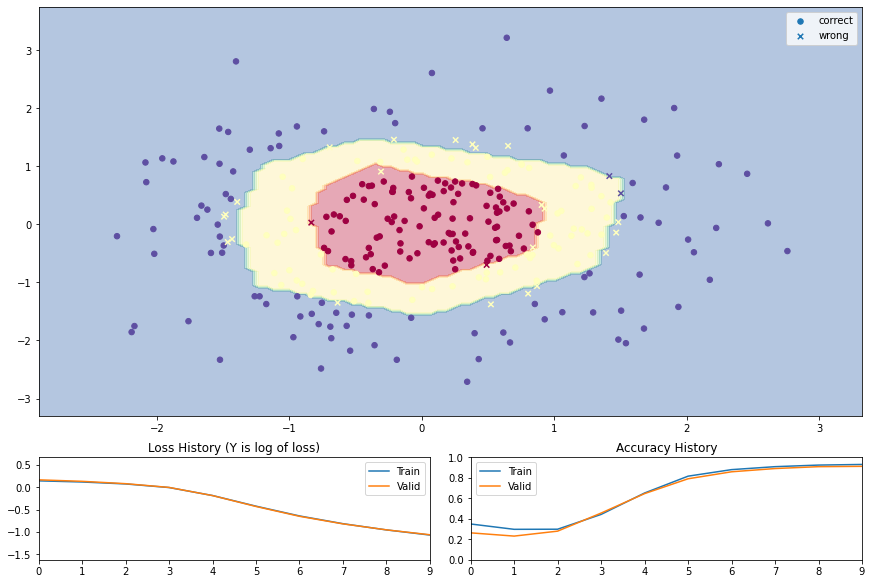

In [180]:
# Draw the training process
draw_process(model, loss_his, acc_his, eval_his)

Accuracy: 0.9


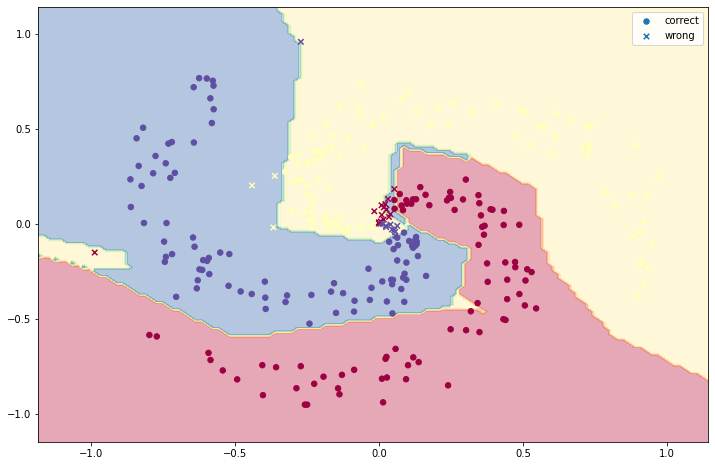

In [152]:
# Final evaluation on testing data
accuracy, evaluation_result = model.evaluate(testing_data)
print("Accuracy:", accuracy)
draw_model_boundary(calculate_model_boundary(model, evaluation_result))

### Experiments

Do some experiments on the effect of different settings

#### Try out different daasets
- Must: "checkboard", "spiral", "mul_circle"
- Others: "circle", "moon", "blob"

#### Try out different activation functions
- Must: AF.linear, AF.sigmoid, AF.tanh, AF.relu
- Others: AF.leaky_relu, AF.selu ...

#### Try out different model structures (deep vs shallow / wide vs thin)
- Must: (4)x1, (2)x4, (4)x2
- Others: (4)x3 ...

#### Try out different Gradient Descent Methods
- Must: Batch, Stochastic, Mini-batch with different batch size

#### Try out Different Optimizers
- Must: SGD, SGD+Momentum, RMSprop, Adam
- Others: SGD+NesterovMomentum, Adagrad

#### Must: Try out Early Stopping

#### Must: Try out Learning Rate Adjustment

#### Others: Try out different weight and bias initialization
- Eg. weights: Standard Normal, Normalized Standard Normal, Gaussian Normal
- Eg. bias: All zeros, Standard Normal, Gaussian Normal

### Compare with Different Dataset
##### 1. mul_circle
不同label間的Boundary明顯，因此使用預設的[4, 4]模型就能有效分辨。
##### 2. checkboard
由於資料分布較為複雜，使用[4, 4]或[2, 2, 2, 2]皆會有一部分的label無法被正確classify，但相較之下[2, 2, 2, 2]有比較好的表現，因此需要加深或加廣模型，比如使用[8, 8]的模型。
##### 3. spiral
在資料點分散的地方，模型可以預測得很精準，但在中心資料聚集處容易預測錯誤，即使將模型加廣到[8, 8]仍會有些許錯誤。

### Try Different Activation Functions
##### 1. linear
由於無法提供non-linearity，對於不是由線性boundary區分label的資料無法做出有效的classification。

##### 2. sigmoid
由於提供了non-linearity，能讓模型有效進行本次分類任務，但sigmoid可能會造成梯度消失問題。

##### 3. tanh
與sigmoid類似，好處是輸出是以0為中心，但在本次的分類中模型表現比使用sigmoid差。

##### 4. relu
表現最好的activation function，解決sigmoid與tanh的梯度消失問題，但在應用上要小心dead relu以及梯度爆炸的問題。

### Try Different Model Structures

在task簡單的情況下(如mul_circle)，使用[4]的model就可以有很好的預測效果，並且模型訓練的速度也會比較快，但面對較為複雜的task就無法起到很好的效果。

使用[2, 2, 2, 2]的模型架構時，推測由於每層的unit較少，導致模型表現不佳，但只要每層增加為3至4個unit後即可在本次的task中有良好的表現。

[4, 4]的模型可以有效處理spiral與mul_circle，但面對checkboard時就需要再加深模型。

### Try Different Gradient Descent Methods
在使用不同batch size訓練時，發現較大的batch size會使模型訓練的速度較慢，需要使用更大的lr，但是相比小的batch size來說，由於每次更新梯度看過的資料較多，因此訓練上較為穩定；使用mini batch可以讓模型訓練有更多不同的方向，尤其在stochastic時每經過一個sample就會更新一次權重，但與大的Batch size相比訓練會比較不穩定。

### Try Different Optimizers

##### 1. SGD
標準的梯度下降，訓練後期可能會在同樣的地方來回橫跳，或卡在某個點。

##### 2. SGD+momentum
透過增加momentum來解決卡在local minimum的問題。由於momentum讓同個方向的梯度更新的更快，因此在此次的task中loss下降與accuracy上升的趨勢比SGD更快。

##### 3. RMSprop
RMSprop會自適應的去調整lr，在此次的task中，使用RMSprop使初期的訓練速度非常快，然而在訓練中後期時loss下降的速度變得十分緩慢。

##### 4. Adam
Adam結合了RMSprop與momentum，理應有比RMSprop再穩定一些的表現，然而或許是實作上有疏忽的地方，在此次task中反而表現不佳，且需要將lr調到非常小，否則模型loss幾乎無法下降。

### Try Early Stopping
使用Early Stopping後，若模型表現在一定epoch內沒有明顯進步，就會停止訓練，預防了overfitting的同時也節省訓練時間，但若參數設置不好可能會讓模型在還沒完全學好就被中止。

### Try Learning Rate Adjust
使用LR adjust後，若模型表現在一定epoch內沒有明顯進步，就會降低LR，有可能因此解決再同樣的點反覆橫跳的問題，在訓練後期調降LR使最終模型表現有微幅的進步。可以配合Early Stopping，在調低LR後若表現仍然沒有進步再終止訓練。
